# Elaborato

## Install

In [ ]:
pip install -U tensorflow_privacy

In [ ]:
pip install dill

## Import

In [24]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
import os
import sys
import collections
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
import dill

from typing import Tuple
from scipy import special
from sklearn import metrics
from scipy import special
from numpy import indices
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, classification_report


# Set verbosity.
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)


In [25]:
#dill.load_session('mia_tfp_cifar_001.db')

In [26]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report
import tensorflow_privacy

## Dataset

In [27]:
num_classes = 10
activation = 'relu'
batch_size = 50
epochs_per_report = 2
total_epochs = 50
lr = 0.001
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
reg_lambda = 0.01

In [28]:
train_ds = tfds.as_numpy(
    tfds.load('cifar10', split=tfds.Split.TRAIN, batch_size=-1))
test_ds = tfds.as_numpy(
    tfds.load('cifar10', split=tfds.Split.TEST, batch_size=-1))
x_train = train_ds['image'].astype('float32') / 255.
y_train_indices = train_ds['label'][:, np.newaxis]
x_test = test_ds['image'].astype('float32') / 255.
y_test_indices = test_ds['label'][:, np.newaxis]

x_train, x_toss, y_train_indices, y_toss = train_test_split(x_train, y_train_indices, test_size=0.5)
x_test, x_toss, y_test_indices, y_toss = train_test_split(x_test, y_test_indices, test_size=0.5)

x_train, x_valid, y_train_indices, y_valid_indices = train_test_split(
    x_train, y_train_indices, test_size=0.1)

y_train = tf.keras.utils.to_categorical(y_train_indices, num_classes)
y_test = tf.keras.utils.to_categorical(y_test_indices, num_classes)

y_valid = tf.keras.utils.to_categorical(y_valid_indices, num_classes)

input_shape = x_train.shape[1:]

assert x_train.shape[0] % batch_size == 0

In [29]:
y_test[:, 0]

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [30]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [31]:
y_train.shape

(22500, 10)

In [32]:
y_train_indices[:, 0]

array([8, 5, 8, ..., 9, 4, 8])

In [33]:
x_train.shape[1:]

(32, 32, 3)

## Function

In [34]:
def small_cnn(input_shape: Tuple[int],
              num_classes: int,
              num_conv: int,
              regularizer: tf.keras.regularizers,
              activation: str = 'relu') -> tf.keras.models.Sequential:
  
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(shape=input_shape))

  # Conv layers
  for _ in range(num_conv):
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation, kernel_regularizer=regularizer))
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(64, activation=activation))
  model.add(tf.keras.layers.Dense(num_classes))

  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=['accuracy'])

  return model


In [35]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
  def __init__(self, epochs_per_report, model_name, attack):
    self.epochs_per_report = epochs_per_report
    self.model_name = model_name
    self.attack_results = []
    self.attack = attack

  def on_epoch_end(self, epoch, logs=None):
    epoch = epoch+1

    if epoch % self.epochs_per_report != 0:
      return

    print(f'\nRunning privacy report for epoch: {epoch}\n')

    logits_train = self.model.predict(x_train, batch_size=batch_size)
    logits_test = self.model.predict(x_test, batch_size=batch_size)

    prob_train = special.softmax(logits_train, axis=1)
    prob_test = special.softmax(logits_test, axis=1)

    privacy_report_metadata = PrivacyReportMetadata(
        accuracy_train=logs['val_accuracy'], 
        accuracy_test=logs['val_accuracy'],
        epoch_num=epoch,
        model_variant_label=self.model_name)

    attack_results = mia.run_attacks(
        AttackInputData(
            labels_train=y_train_indices[:, 0],
            labels_test=y_test_indices[:, 0],
            probs_train=prob_train,
            probs_test=prob_test),
        SlicingSpec(entire_dataset=True, by_class=True),
        attack_types=[self.attack],
        #AttackType.THRESHOLD_ATTACK,AttackType.LOGISTIC_REGRESSION,
        privacy_report_metadata=privacy_report_metadata)

    self.attack_results.append(attack_results)

In [36]:
def fit_and_report(title: str,
                  model: tf.keras.models.Sequential,
                  x_train, y_train, x_valid, y_valid, n_epochs, reports_tr, reports_lr):
    
    callback_threshold = PrivacyMetrics(epochs_per_report, title, AttackType.THRESHOLD_ATTACK)
    callback_logreg = PrivacyMetrics(epochs_per_report, title, AttackType.LOGISTIC_REGRESSION)

    history = model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=n_epochs,
      validation_data=(x_valid, y_valid),
      callbacks=[callback_threshold, callback_logreg],
      shuffle=True)

    reports_tr.extend(callback_threshold.attack_results)
    reports_lr.extend(callback_logreg.attack_results)

    save_model(model, title)
    #save_report(callback.attack_results, title + '_report')

In [37]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

In [38]:
def load_model(filename):
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [39]:
def save_report(reports, filename):
    _file = filename + '.py'
    with open(_file, 'w') as file:
        file.write(reports)

In [40]:
def load_report():
    with open('reports.py', 'w') as file:
        return file.read(reports)

## Base model 

In [41]:
cifar_reports_tr = []
cifar_reports_lr = []

In [42]:
model_base = small_cnn(input_shape, num_classes, num_conv=2, regularizer=None, activation=activation)

In [43]:
fit_and_report('basemodel', model_base, x_train, y_train, x_valid, 
               y_valid, total_epochs, cifar_reports_tr, cifar_reports_lr)

Epoch 1/50
450/450 [==============================] - 5s 10ms/step - loss: 1.7412 - accuracy: 0.3658 - val_loss: 1.4377 - val_accuracy: 0.4788
Epoch 2/50
447/450 [============================>.] - ETA: 0s - loss: 1.3802 - accuracy: 0.5059
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

450/450 [==============================] - 12s 26ms/step - loss: 1.3800 - accuracy: 0.5060 - val_loss: 1.3005 - val_accuracy: 0.5388
Epoch 3/50
450/450 [==============================] - 5s 10ms/step - loss: 1.2472 - accuracy: 0.5628 - val_loss: 1.2169 - val_accuracy: 0.5600
Epoch 4/50
448/450 [============================>.] - ETA: 0s - loss: 1.1449 - accuracy: 0.5990
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

450/450 [==============================] - 12s 26ms/step - loss: 1.1449 - accuracy: 0.5991 - val_loss: 1.1510 - val_accuracy: 0.6

In [44]:
model_base.evaluate(x_test,y_test)

157/157 [==============================] - 1s 3ms/step - loss: 2.9627 - accuracy: 0.6000


[2.962663173675537, 0.6000000238418579]

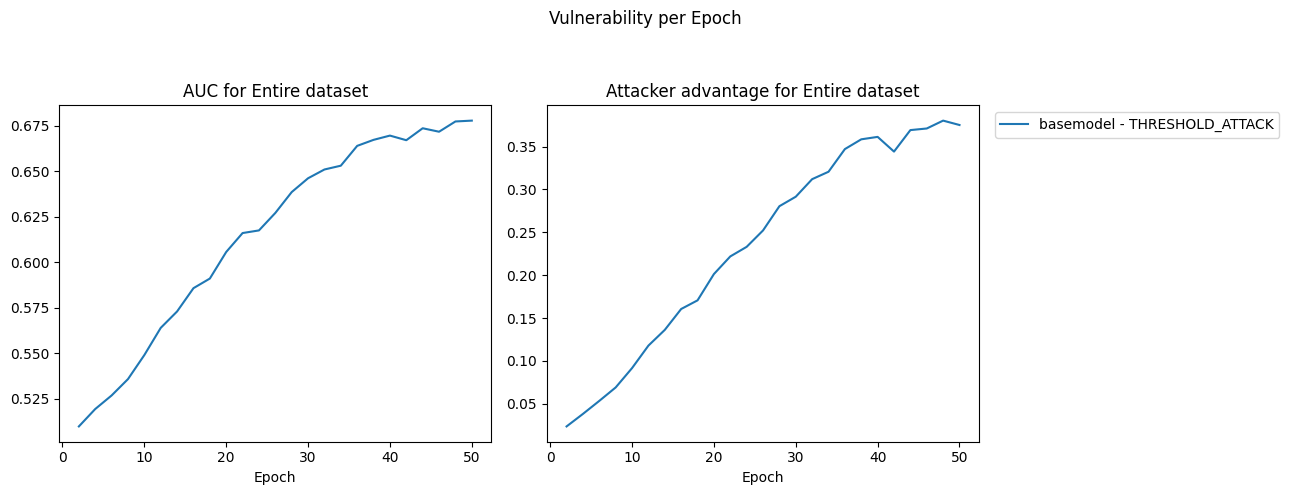

In [45]:
results_tr = AttackResultsCollection(cifar_reports_tr)
epoch_plot = privacy_report.plot_by_epochs(results_tr, privacy_metrics=privacy_metrics)

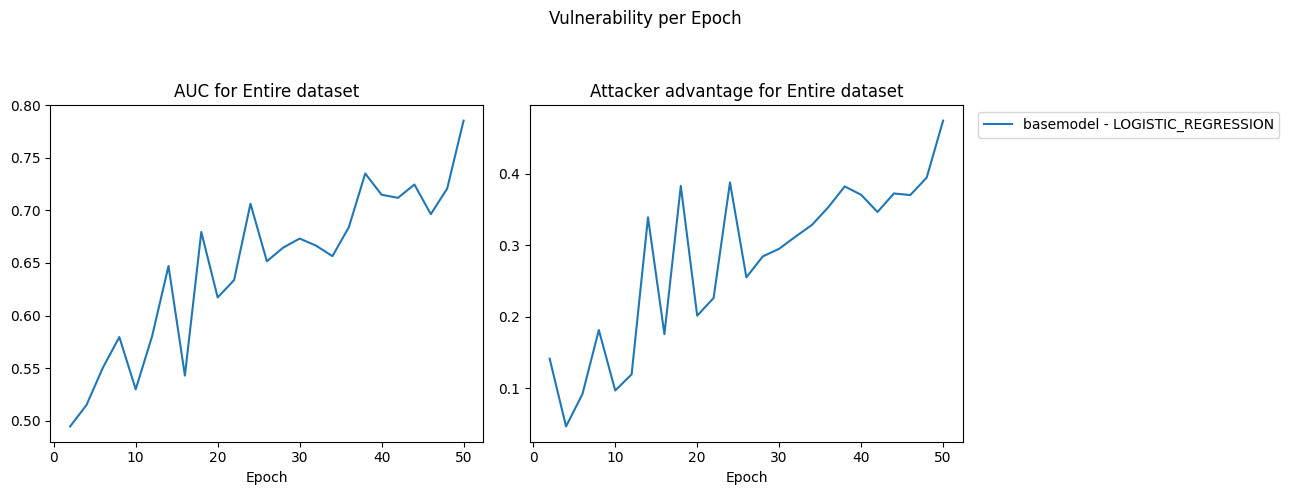

In [46]:
results_lr = AttackResultsCollection(cifar_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [47]:
#dill.dump_session('mia_tfp_cifar_001.db')

PicklingError: Can't pickle <function _make_type_validator.<locals>.validate_int at 0x7fc22f313430>: it's not found as matplotlib.rcsetup._make_type_validator.<locals>.validate_int

## L1 regularization 

In [48]:
regL1 = tf.keras.regularizers.L1(l1=reg_lambda)

model_l1 = small_cnn(input_shape, num_classes, num_conv=2, regularizer=regL1, 
                       activation=activation)

In [49]:
fit_and_report('l1', model_l1, x_train, y_train, x_valid, y_valid, total_epochs, 
               cifar_reports_tr, cifar_reports_lr)

Epoch 1/50
450/450 [==============================] - 6s 11ms/step - loss: 2.6965 - accuracy: 0.2401 - val_loss: 2.0970 - val_accuracy: 0.2788
Epoch 2/50
447/450 [============================>.] - ETA: 0s - loss: 2.0159 - accuracy: 0.3199
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

450/450 [==============================] - 14s 31ms/step - loss: 2.0151 - accuracy: 0.3199 - val_loss: 1.9163 - val_accuracy: 0.3676
Epoch 3/50
450/450 [==============================] - 5s 11ms/step - loss: 1.8678 - accuracy: 0.3782 - val_loss: 1.8147 - val_accuracy: 0.3924
Epoch 4/50
448/450 [============================>.] - ETA: 0s - loss: 1.7705 - accuracy: 0.4156
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

450/450 [==============================] - 13s 29ms/step - loss: 1.7709 - accuracy: 0.4154 - val_loss: 1.7759 - val_accuracy: 0.4

In [50]:
model_l1.evaluate(x_test,y_test)

157/157 [==============================] - 1s 2ms/step - loss: 1.5091 - accuracy: 0.5180


[1.5090980529785156, 0.5180000066757202]

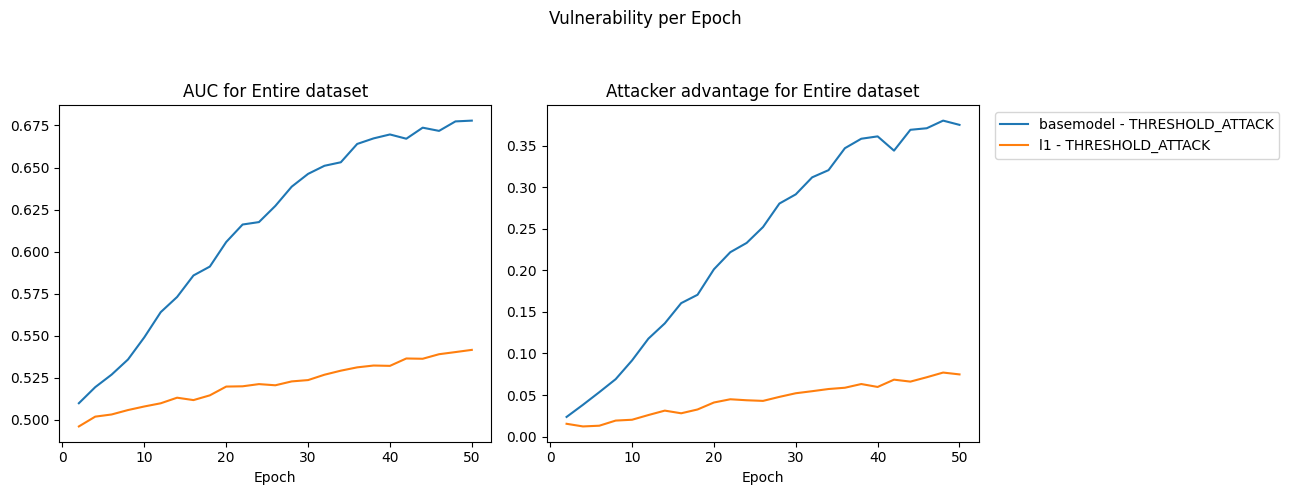

In [51]:
results_tr = AttackResultsCollection(cifar_reports_tr)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results_tr, privacy_metrics=privacy_metrics)

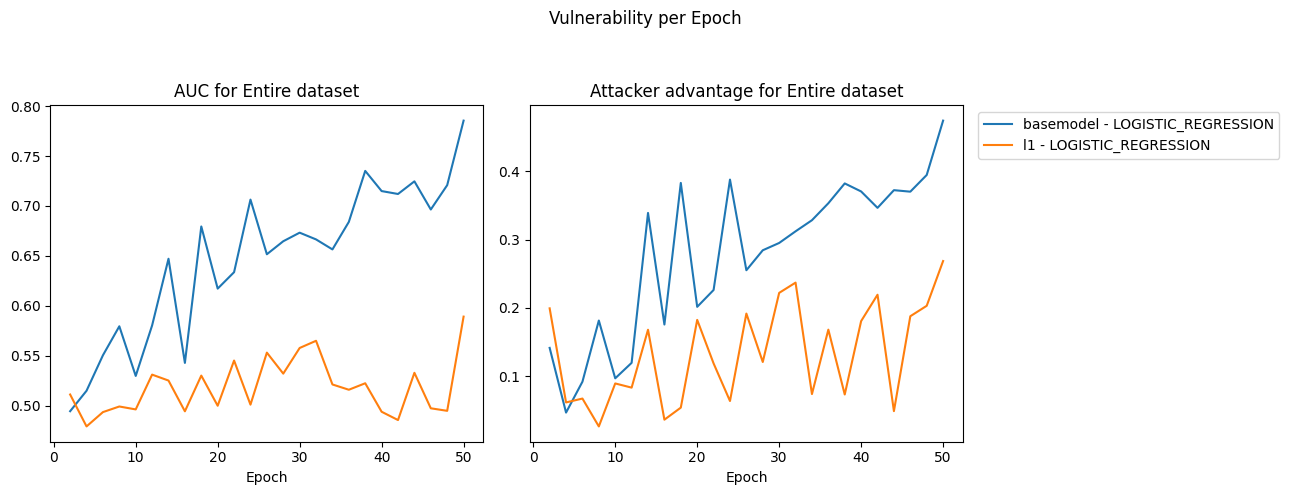

In [52]:
results_lr = AttackResultsCollection(cifar_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [53]:
#dill.dump_session('mia_tfp_cifar_001.db')

## L2 regularization

In [54]:
regL2 = tf.keras.regularizers.L2(l2=reg_lambda)

model_l2 = small_cnn(input_shape, num_classes, num_conv=2, regularizer=regL2, 
                       activation=activation)

In [55]:
fit_and_report('l2', model_l2, x_train, y_train, x_valid, y_valid, total_epochs, 
              cifar_reports_tr, cifar_reports_lr)

Epoch 1/50
450/450 [==============================] - 5s 11ms/step - loss: 1.9252 - accuracy: 0.3478 - val_loss: 1.6475 - val_accuracy: 0.4480
Epoch 2/50
450/450 [==============================] - ETA: 0s - loss: 1.5889 - accuracy: 0.4641
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

450/450 [==============================] - 14s 31ms/step - loss: 1.5889 - accuracy: 0.4641 - val_loss: 1.6384 - val_accuracy: 0.4676
Epoch 3/50
450/450 [==============================] - 5s 11ms/step - loss: 1.4968 - accuracy: 0.5039 - val_loss: 1.4559 - val_accuracy: 0.5184
Epoch 4/50
448/450 [============================>.] - ETA: 0s - loss: 1.4262 - accuracy: 0.5275
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

450/450 [==============================] - 13s 29ms/step - loss: 1.4263 - accuracy: 0.5272 - val_loss: 1.4318 - val_accuracy: 0.5

In [56]:
model_l2.evaluate(x_test,y_test)

157/157 [==============================] - 1s 2ms/step - loss: 1.2686 - accuracy: 0.6368


[1.2685869932174683, 0.6367999911308289]

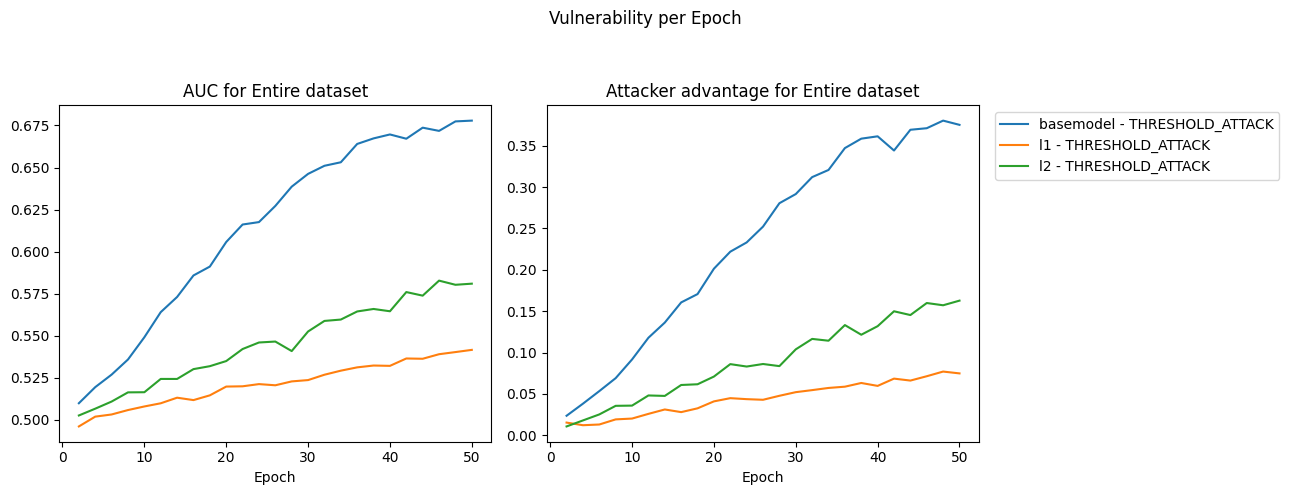

In [57]:
results_tr = AttackResultsCollection(cifar_reports_tr)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results_tr, privacy_metrics=privacy_metrics)

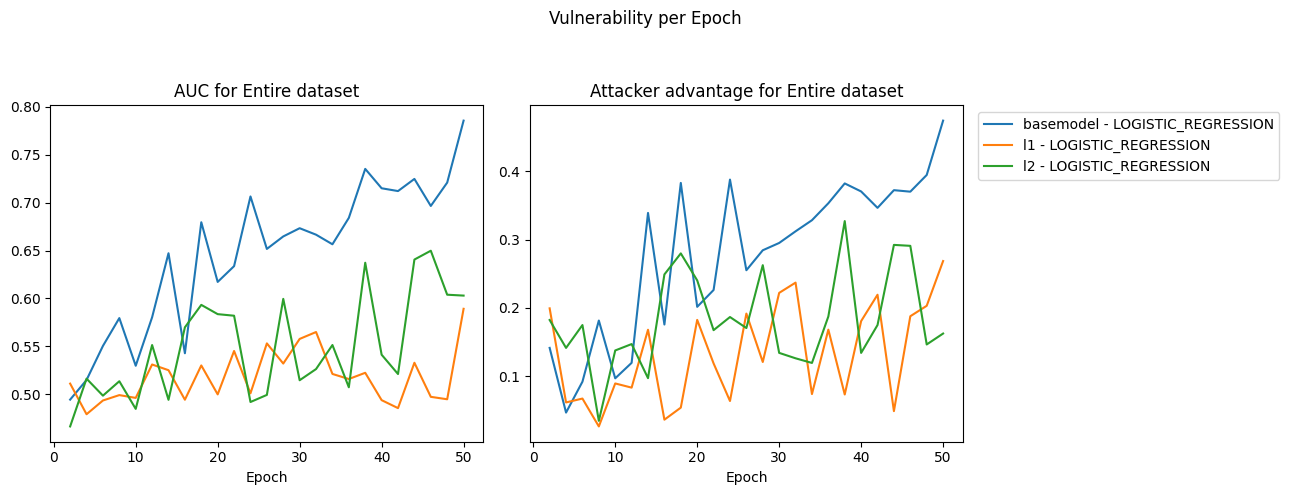

In [58]:
results_lr = AttackResultsCollection(cifar_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [59]:
#dill.dump_session('mia_tfp_cifar_001.db')

## L1L2

In [60]:
regL1L2 = tf.keras.regularizers.L1L2(l2=reg_lambda, l1=reg_lambda)

model_l1l2 = small_cnn(input_shape, num_classes, num_conv=2, regularizer=regL1L2, 
                       activation=activation)

In [ ]:
fit_and_report('l1l2', model_l1l2, x_train, y_train, x_valid, y_valid, total_epochs, 
              cifar_reports_tr, cifar_reports_lr)

Epoch 1/50
450/450 [==============================] - 5s 10ms/step - loss: 2.6685 - accuracy: 0.2208 - val_loss: 2.0781 - val_accuracy: 0.2932
Epoch 2/50
448/450 [============================>.] - ETA: 0s - loss: 1.9860 - accuracy: 0.3212
Running privacy report for epoch: 2

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 2

450/450 [==============================] - 12s 28ms/step - loss: 1.9853 - accuracy: 0.3213 - val_loss: 1.9884 - val_accuracy: 0.3364
Epoch 3/50
450/450 [==============================] - 4s 10ms/step - loss: 1.8547 - accuracy: 0.3752 - val_loss: 1.8835 - val_accuracy: 0.3676
Epoch 4/50
445/450 [============================>.] - ETA: 0s - loss: 1.7809 - accuracy: 0.4040
Running privacy report for epoch: 4

100/100 [==============================] - 0s 3ms/step

Running privacy report for epoch: 4

450/450 [==============================] - 12s 27ms/step - loss: 1.7804 - accuracy: 0.4044 - val_loss: 1.7828 - val_accuracy: 0.4

In [ ]:
model_l1l2.evaluate(x_test,y_test)

In [ ]:
results_tr = AttackResultsCollection(cifar_reports_tr)
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)
epoch_plot = privacy_report.plot_by_epochs(
    results_tr, privacy_metrics=privacy_metrics)

In [ ]:
results_lr = AttackResultsCollection(cifar_reports_lr)
epoch_plot = privacy_report.plot_by_epochs(results_lr, privacy_metrics=privacy_metrics)

In [ ]:
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results_tr, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

In [ ]:
utility_privacy_plot = privacy_report.plot_privacy_vs_accuracy(
    results_lr, privacy_metrics=privacy_metrics)

for axis in utility_privacy_plot.axes:
  axis.set_xlabel('Validation accuracy')

In [ ]:
#dill.dump_session('mia_tfp_cifar_001.db')